In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import time
from bs4 import BeautifulSoup
import twint
import nest_asyncio
nest_asyncio.apply()

### Webscraping

In [ ]:
url = "https://triagecancer.org/congressional-social-media"
soup = BeautifulSoup(requests.get(url).text)

In [ ]:
containers = [soup.findAll('tr', {"class": f"ninja_table_row_{num}"}) for num in range(541)]

In [ ]:
names = [c[0].findAll("td")[2].text for c in containers]

In [ ]:
parties = [c[0].findAll("td")[4].text for c in containers]

In [ ]:
handles = [c[0].findAll("td")[5].text for c in containers]

In [ ]:
twitter_df = pd.DataFrame(columns = ["name", "party", "t_handle"])
twitter_df["name"] = names
twitter_df["party"] = parties
twitter_df["t_handle"] = handles

In [ ]:
twitter_df["t_handle"] = twitter_df["t_handle"].map(lambda x: x.strip("@"))

In [ ]:
add_names = ["Biden, Joe", "Clinton, Hillary", "Obama, Barack", "Pence, Mike", "Pompeo, Mike"]
add_parties = ["D", "D", "D", "R", "R"]
add_handles = ["JoeBiden", "HillaryClinton", "BarackObama", "Mike_Pence", "mikepompeo"]
d = {'name': add_names, 'party': add_parties, 't_handle': add_handles}
add_df = pd.DataFrame(data=d)

In [ ]:
twitter_df = twitter_df.append(add_df)

In [ ]:
most_popular = twitter_df[twitter_df["t_handle"].isin(["HillaryClinton", "JoeBiden", 
                                                   "BarackObama", "SenSanders",
                                                  "Mike_Pence","KamalaHarris"])]

In [ ]:
less_popular = twitter_df[~twitter_df["t_handle"].isin(["HillaryClinton", "JoeBiden", 
                                                   "BarackObama", "SenSanders",
                                                  "Mike_Pence","KamalaHarris"])]

### Extracting Data from Twint

In [ ]:
def extract_twint(user, since, min_likes):
    c = twint.Config()
    c.Username = user
    c.Since = since
    c.Lang = "en"
    c.Min_likes = min_likes
    c.Popular_tweets = True
    c.Pandas = True
    c.Hide_output = True
    twint.run.Search(c)
    df = twint.storage.panda.Tweets_df
    return df

In [ ]:
def extract_all(df, since, min_likes):
    users = list(df["t_handle"])
    data = pd.DataFrame([])
    for u in users:
        try:
            u_df = extract_twint(u, since, min_likes)
            data = data.append(u_df)
        except ValueError:
            continue
    return data

In [ ]:
tweets_less = extract_all(less_popular,'2016-01-01', 50)

In [ ]:
tweets_more = extract_all(most_popular,'2016-01-01', 500)

In [ ]:
tweets_less.shape

In [ ]:
tweets_less = tweets_less[tweets_less["language"] == "en"]

In [ ]:
tweets_all = tweets_less.append(tweets_more)

In [ ]:
tweets_all = tweets_all[tweets_all["language"] == "en"]

In [ ]:
tweets_all = tweets_all[["id", "date", "tweet", "language", "username", "nlikes", "hashtags"]]

In [ ]:
tweets_all["characters"] = tweets_all["tweet"].map(lambda x: len(x))

In [ ]:
tweets_all.to_csv("Data/tweets_all.csv")

In [ ]:
tweets_all = pd.read_csv("Data/tweets_all.csv")

In [ ]:
tweets_all.drop(columns = "Unnamed: 0", inplace=True)

In [ ]:
twitter_df.rename(columns={"t_handle": "username"}, inplace=True)

In [ ]:
expanded_df = tweets_all.join(twitter_df.set_index("username"), on="username", how="left")

In [ ]:
cols = ['id', 'name', 'username', 'date', 'tweet', 'characters', 'language', 'nlikes', 'hashtags','party']
expanded_df = expanded_df[cols]

In [ ]:
expanded_df = expanded_df[expanded_df["characters"] > 50]

In [ ]:
expanded_df["date"] = pd.to_datetime(expanded_df["date"])

In [ ]:
expanded_df.drop_duplicates(subset="id", inplace=True)

In [ ]:
expanded_df.head()

In [ ]:
expanded_df.to_csv("Data/expanded_df.csv", index=False)

In [2]:
expanded_df = pd.read_csv("Data/expanded_df.csv")

Since there are tweets from only two independent politicians, we will either drop them or label them as republican or democrat. We will drop Angus King, but label Bernie Sanders as "D", due to him running under the democratic party during the 2020 election.

In [4]:
expanded_df.drop(expanded_df[expanded_df['name'] == "Angus King"].index, inplace = True)

In [5]:
expanded_df.loc[(expanded_df["name"] == 'Sanders, Bernie'),"party"]="D"

We will now check for Nan values

In [6]:
expanded_df.isna().sum()

id                0
name          22491
username          0
date              0
tweet             0
characters        0
language          0
nlikes            0
hashtags          0
party         22491
dtype: int64

In [7]:
expanded_df.loc[(expanded_df["party"] != 'R')&(expanded_df["party"] != 'D')]["username"].value_counts()[:50]

justinamash        3267
SenatorTomUdall    2411
mattgaetz          2018
RepDougCollins     1589
DougJones          1277
TulsiPress         1159
SteveKingIA        1011
RepDavids           803
SenCoryGardner      793
RepCunningham       636
sendavidperdue      625
RepDMP              598
SenatorLoeffler     579
repjohnlewis        526
HurdOnTheHill       514
RepHarley           441
RepMarkWalker       414
RepRiggleman        398
SenAlexander        326
braun4indiana       291
RepPeteKing         281
RepEliotEngel       243
RepTedYoho          199
RepByrne            163
NitaLowey           122
RepTorresSmall      118
LacyClayMO1         104
RepMaxRose          103
andybiggs4az        102
JimLangevin          89
SenPatRoberts        80
RepRossSpano         73
RepAbraham           73
repgregwalden        73
RepKirkpatrick       73
RepGilCisneros       70
jamie_raskin         66
RepBrindisi          62
RepJoseSerrano       60
SusanWBrooks         59
RepFinkenauer        58
RepMikeRogersAL 

To preserve data, we will label the politicians that do not have a party based on their political affiliations.

In [8]:
expanded_df.loc[(expanded_df["username"] == 'SenatorTomUdall'),"party"]="D"
expanded_df.loc[(expanded_df["username"] == 'SenatorTomUdall'),"name"]="Udall, Tom"

In [9]:
expanded_df.loc[(expanded_df["username"] == 'mattgaetz'),"party"]="R"
expanded_df.loc[(expanded_df["username"] == 'mattgaetz'),"name"]="Gaetz, Matt"

In [10]:
expanded_df.loc[(expanded_df["username"] == 'RepDougCollins'),"party"]="R"
expanded_df.loc[(expanded_df["username"] == 'RepDougCollins'),"name"]="Collins, Doug"

In [11]:
expanded_df.loc[(expanded_df["username"] == 'DougJones'),"party"]="D"
expanded_df.loc[(expanded_df["username"] == 'DougJones'),"name"]="Jones, Doug"

In [12]:
expanded_df.loc[(expanded_df["username"] == 'TulsiPress'),"party"]="D"
expanded_df.loc[(expanded_df["username"] == 'TulsiPress'),"name"]="Gabbard, Tulsi"

In [13]:
expanded_df.loc[(expanded_df["username"] == 'SteveKingIA'),"party"]="R"
expanded_df.loc[(expanded_df["username"] == 'SteveKingIA'),"name"]="King, Steve"

In [14]:
expanded_df.loc[(expanded_df["username"] == 'RepDavids'),"party"]="D"
expanded_df.loc[(expanded_df["username"] == 'RepDavids'),"name"]="Davids, Sharice"

In [15]:
expanded_df.loc[(expanded_df["username"] == 'SenCoryGardner'),"party"]="R"
expanded_df.loc[(expanded_df["username"] == 'SenCoryGardner'),"name"]="Gardner, Cory"

In [16]:
expanded_df.loc[(expanded_df["username"] == 'RepCunningham'),"party"]="D"
expanded_df.loc[(expanded_df["username"] == 'RepCunningham'),"name"]="Cunningham, Joe"

In [18]:
expanded_df.loc[(expanded_df["username"] == 'sendavidperdue'),"party"]="R"
expanded_df.loc[(expanded_df["username"] == 'sendavidperdue'),"name"]="Perdue, David"

In [19]:
expanded_df.loc[(expanded_df["username"] == 'RepDMP'),"party"]="D"
expanded_df.loc[(expanded_df["username"] == 'RepDMP'),"name"]="Mucarsel-Powell, Debbie"

In [20]:
expanded_df.loc[(expanded_df["username"] == 'SenatorLoeffler'),"party"]="R"
expanded_df.loc[(expanded_df["username"] == 'SenatorLoeffler'),"name"]="Loeffler, Kelly"

In [21]:
expanded_df.loc[(expanded_df["username"] == 'repjohnlewis'),"party"]="D"
expanded_df.loc[(expanded_df["username"] == 'repjohnlewis'),"name"]="Lewis, John"

In [22]:
expanded_df.loc[(expanded_df["username"] == 'HurdOnTheHill'),"party"]="R"
expanded_df.loc[(expanded_df["username"] == 'HurdOnTheHill'),"name"]="Hurd, Will"

In [23]:
expanded_df.dropna(inplace=True)

### Data Preprocessing and EDA

In [56]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from  nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
import re
import preprocessor as p
import spacy
nlp = spacy.load("en_core_web_sm")
from wordcloud import WordCloud, ImageColorGenerator
import gensim
from gensim.utils import simple_preprocess

In [25]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
stopwords_list = stopwords.words("english")

In [26]:
stopwords_list.append("&amp")
stopwords_list.append("amp")

In [27]:
def process_text(text, pattern):
    text = p.clean(text)
    raw = nltk.regexp_tokenize(text, pattern)
    lower_tokens = [w.lower() for w in raw]
    words_stopped = [w for w in lower_tokens if w not in stopwords_list]
    separator = ' '
    sentence = separator.join(words_stopped)
    return sentence

In [28]:
def lemmatize(text):
    w_ls = []
    for word in nlp(text):
        w_ls.append(word.lemma_)
    separator = ' '
    sentence = separator.join(w_ls)
    return sentence

In [29]:
preprocess = expanded_df.copy()

In [30]:
preprocess["tokens"] = preprocess["tweet"].map(lambda x: process_text(x, pattern))

In [31]:
preprocess["lemmatized"] = preprocess["tokens"].map(lambda x: lemmatize(x))

In [32]:
preprocess.head()

,id,name,username,date,tweet,characters,language,nlikes,hashtags,party,tokens,lemmatized
0,1358826533310390272,"Shelby, Richard",SenShelby,2021-02-08 11:14:25,"Although I plan to retire, I am not leaving to...",270,en,154,[],R,although plan retire leaving today two good ye...,although plan retire leave today two good year...
1,1358826532450541573,"Shelby, Richard",SenShelby,2021-02-08 11:14:25,Today I announce that I will not seek a sevent...,232,en,617,[],R,today announce seek seventh term senate everyt...,today announce seek seventh term senate everyt...
2,1358538474639544321,"Shelby, Richard",SenShelby,2021-02-07 16:09:47,George Shultz was a great statesman. He held f...,206,en,112,[],R,george shultz great statesman held four cabine...,george shultz great statesman hold four cabine...
3,1357132614071689217,"Shelby, Richard",SenShelby,2021-02-03 19:03:24,"Congratulations to Ann Berry, the new Secretar...",275,en,220,[],R,congratulations ann berry new secretary senate...,congratulation ann berry new secretary senate ...
4,1357059443435991046,"Shelby, Richard",SenShelby,2021-02-03 14:12:38,"Cosponsored a resolution, which just passed in...",279,en,144,[],R,cosponsored resolution passed senate honoring ...,cosponsor resolution pass senate honor life le...


In [33]:
preprocess["lemmatized"].str.split(expand=True).stack().value_counts()[:50]

trump         53769
american      53418
today         40148
president     39675
people        37988
need          37478
make          36008
we            35668
work          35504
nt            33999
must          32322
I             31636
's            30972
family        29871
be            28501
get           28301
right         27389
time          27217
vote          27152
health        25121
year          24776
one           24275
day           24197
bill          23968
act           23521
country       23009
fight         22998
congress      22873
care          22828
take          22709
senate        22576
house         22149
state         21269
help          21017
go            19713
republican    19632
pass          19589
would         19343
support       19199
protect       18568
do            18028
thank         17941
new           17699
america       17648
woman         17335
say           16521
community     16446
know          16393
like          16123
keep          16045


It appears that some of the words will still need to be cleaned.

In [ ]:
#banned = []
#f = lambda x: ' '.join([item for item in x.split() if item not in banned])
#preprocess["tokens"] = preprocess["tokens"].map(f)

In [ ]:
##preprocess["freq_dist"] = preprocess["tokens"].map(lambda x: FreqDist(x))

In [11]:
## Each word always going to be a column? Just categorical variables with some words? How do you set up your dataframe? 

In [ ]:
## Total words/vocab before removal of stop words? 
#Consider removing tweets with congratulations and thank you
# Turn df into preprocess instead of EDA
# create column for lemmatization

In [34]:
preprocess.to_csv("Data/preprocess.csv", index=False)

In [4]:
preprocess = pd.read_csv("Data/preprocess.csv")

In [5]:
eda = preprocess.copy()

We will now split the dataframe into classes for the EDA.

In [8]:
right = eda[eda["party"] == "R"]
left = eda[eda["party"] == "D"]

In [9]:
right.describe()

,id,characters,nlikes
count,9.858500e+04,98585.000000,98585.000000
mean,1.135173e+18,195.327068,2227.667241
std,1.690853e+17,72.704230,6572.232850
min,6.829092e+17,51.000000,0.000000
25%,1.023591e+18,134.000000,152.000000
50%,1.185202e+18,197.000000,377.000000
75%,1.269314e+18,267.000000,1432.000000
max,1.359657e+18,500.000000,227274.000000


In [10]:
left.describe()

,id,characters,nlikes
count,3.034820e+05,303482.000000,3.034820e+05
mean,1.077427e+18,198.659341,4.573829e+03
std,1.772664e+17,68.976052,3.152003e+04
min,6.828041e+17,51.000000,1.200000e+01
25%,9.258721e+17,139.000000,1.390000e+02
50%,1.091526e+18,198.000000,3.400000e+02
75%,1.233544e+18,267.000000,1.531000e+03
max,1.359659e+18,777.000000,4.281004e+06


Looking at the descriptive statistics for the two classes, both has similar average character length of tweets (195 vs 198), but left leaning politicians recieved significantly more likes on average. 

In [12]:
left["nlikes"].median(), right["nlikes"].median()

(340.0, 377.0)

However, the medians in terms of likes were much more similar.

We will now look at the most common words per class.

In [17]:
right["lemmatized"].str.split(expand=True).stack().value_counts(normalize=True)[:10]

american     0.008257
today        0.006321
work         0.005185
we           0.005062
president    0.004990
people       0.004939
nt           0.004884
time         0.004277
need         0.004235
make         0.004115
dtype: float64

In [18]:
left["lemmatized"].str.split(expand=True).stack().value_counts(normalize=True)[:10]

trump        0.009742
american     0.007919
president    0.006241
need         0.006046
people       0.005925
today        0.005915
make         0.005795
must         0.005448
we           0.005429
work         0.005359
dtype: float64

The most common 10 words in each class are fairly similar, albeit in slightly different proportions. The most commonly used word in left leaning tweets was "Trump" while in right leaning it was "american".

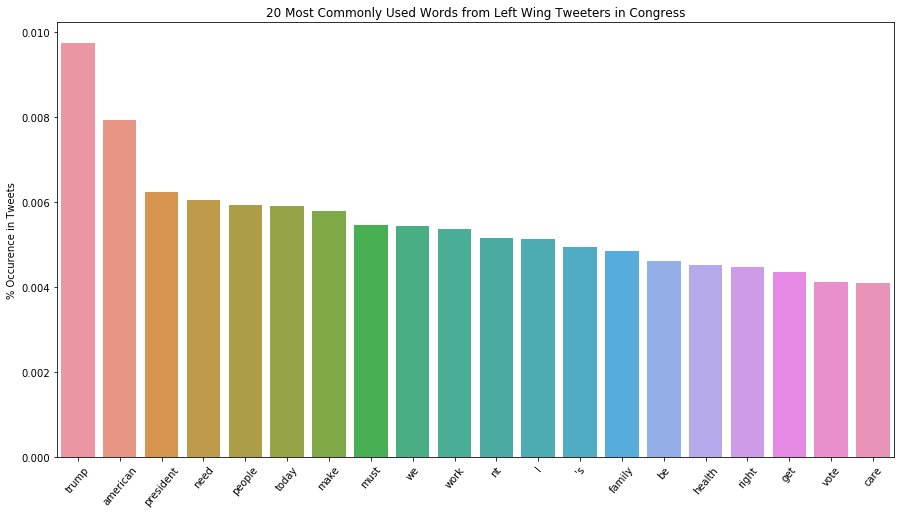

In [34]:
plt.figure(figsize=(15,8))
sns.barplot(x=left["lemmatized"].str.split(expand=True).stack().value_counts(normalize=True)[:20].index,
            y=left["lemmatized"].str.split(expand=True).stack().value_counts(normalize=True)[:20].values)
plt.title("20 Most Commonly Used Words from Left Wing Tweeters in Congress")
plt.ylabel("% Occurence in Tweets")
plt.xticks(rotation=50)
plt.show()

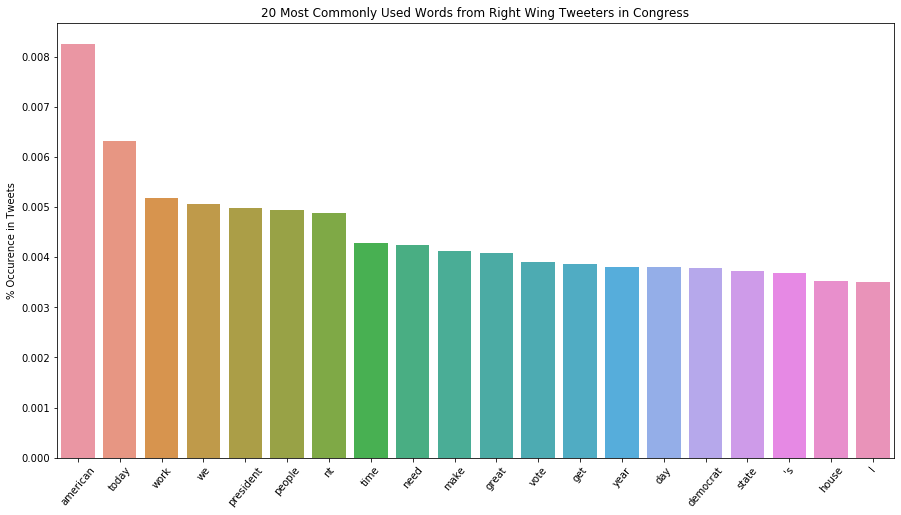

In [33]:
plt.figure(figsize=(15,8))
sns.barplot(x=right["lemmatized"].str.split(expand=True).stack().value_counts(normalize=True)[:20].index,
            y=right["lemmatized"].str.split(expand=True).stack().value_counts(normalize=True)[:20].values)
plt.title("20 Most Commonly Used Words from Right Wing Tweeters in Congress")
plt.ylabel("% Occurence in Tweets")
plt.xticks(rotation=50)
plt.show()

Another way to visualize the most commonly used words for each class is through word clouds, where the more commonly used words are represented in bigger text.

In [45]:
left["lemmatized"].dropna(inplace=True)

0

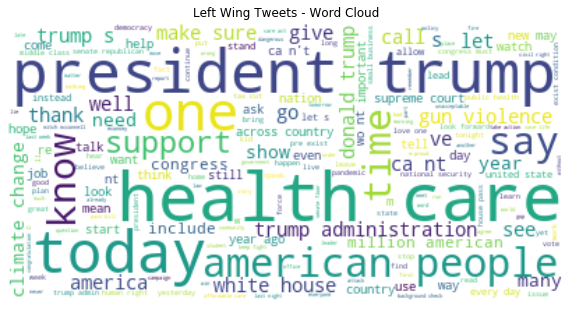

In [58]:
plt.figure(figsize=(10, 8))
left_text = " ".join(tweet for tweet in left["lemmatized"])
wordcloud_l = WordCloud(background_color="white").generate(left_text)
plt.imshow(wordcloud_l, interpolation='bilinear')
plt.axis("off")
plt.title("Left Wing Tweets - Word Cloud")
plt.show()

In [51]:
right["lemmatized"].dropna(inplace=True)

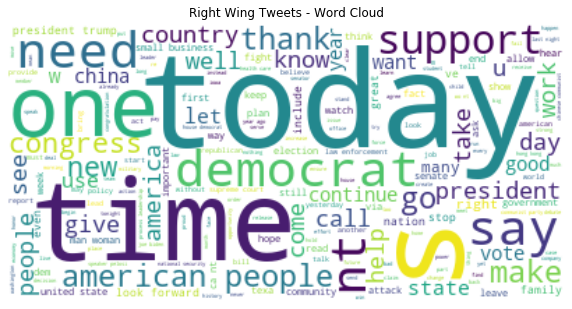

In [59]:
plt.figure(figsize=(10, 8))
right_text = " ".join(tweet for tweet in right["lemmatized"])
wordcloud_r = WordCloud(background_color="white").generate(right_text)
plt.imshow(wordcloud_r, interpolation='bilinear')
plt.axis("off")
plt.title("Right Wing Tweets - Word Cloud")
plt.show()

We will now perform LDA (latent dirichlet allocation) to form topic clusters out of the words in each class.

In [63]:
def list_tokens_lemmas(df, col):
    tokens_list = []
    for sentence in df[col]:
        word_list = []
        for word in sentence.split(" "):
            word_list.append(word)
        tokens_list.append(word_list)
    return tokens_list

In [65]:
left_tokens = list_tokens_lemmas(left, "lemmatized")
right_tokens = list_tokens_lemmas(right, "lemmatized")

In [66]:
left_dict = gensim.corpora.Dictionary(left_tokens)
right_dict = gensim.corpora.Dictionary(right_tokens)

In [67]:
left_dict.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)
right_dict.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

In [68]:
left_corpus = [left_dict.doc2bow(text) for text in left_tokens]
right_corpus = [right_dict.doc2bow(text) for text in right_tokens]

In [71]:
left_lda =  gensim.models.LdaMulticore(left_corpus, 
                                   num_topics = 5, 
                                   id2word = left_dict,                                    
                                   passes = 10,
                                   workers = 2)
left_lda.print_topics()

[(0,
  '0.022*"nt" + 0.017*"vote" + 0.016*"be" + 0.014*"get" + 0.013*"make" + 0.012*"we" + 0.012*"do" + 0.012*"right" + 0.011*"president" + 0.010*"people"'),
 (1,
  '0.013*"today" + 0.011*"country" + 0.011*"woman" + 0.010*"thank" + 0.010*"we" + 0.010*"fight" + 0.009*"I" + 0.009*"year" + 0.008*"day" + 0.008*"work"'),
 (2,
  '0.021*"president" + 0.011*"must" + 0.011*"\'s" + 0.010*"climate" + 0.008*"hillary" + 0.007*"congress" + 0.006*"law" + 0.006*"change" + 0.005*"hold" + 0.005*"administration"'),
 (3,
  '0.018*"need" + 0.012*"pass" + 0.011*"worker" + 0.010*"act" + 0.010*"work" + 0.009*"bill" + 0.009*"help" + 0.008*"crisis" + 0.008*"must" + 0.008*"I"'),
 (4,
  '0.030*"care" + 0.028*"health" + 0.015*"family" + 0.013*"million" + 0.012*"people" + 0.012*"tax" + 0.011*"child" + 0.011*"pay" + 0.009*"would" + 0.008*"cut"')]

Some of the topic clusters for left leaning tweets may be related to voting, health care, legislation, COVID relief.

In [72]:
right_lda =  gensim.models.LdaMulticore(right_corpus, 
                                   num_topics = 5, 
                                   id2word = right_dict,                                    
                                   passes = 10,
                                   workers = 2)
right_lda.print_topics()

[(0,
  '0.013*"job" + 0.011*"work" + 0.011*"need" + 0.010*"bill" + 0.010*"border" + 0.008*"help" + 0.008*"business" + 0.007*"act" + 0.007*"economy" + 0.007*"pass"'),
 (1,
  '0.021*"great" + 0.019*"today" + 0.016*"thank" + 0.012*"day" + 0.010*"america" + 0.010*"year" + 0.010*"join" + 0.010*"we" + 0.009*"president" + 0.009*"honor"'),
 (2,
  '0.021*"nt" + 0.013*"do" + 0.012*"people" + 0.012*"china" + 0.012*"democrat" + 0.009*"be" + 0.008*"get" + 0.008*"we" + 0.007*"want" + 0.007*"s"'),
 (3,
  '0.011*"law" + 0.008*"must" + 0.008*"stand" + 0.007*"we" + 0.007*"police" + 0.006*"iran" + 0.006*"enforcement" + 0.006*"take" + 0.006*"attack" + 0.006*"u"'),
 (4,
  '0.020*"president" + 0.016*"vote" + 0.014*"trump" + 0.012*"senate" + 0.012*"house" + 0.011*"election" + 0.011*"impeachment" + 0.009*"judge" + 0.008*"court" + 0.008*"biden"')]

Some topic clusters for right leaning tweets may include 2020 election, trump impeachment trial, police and the economy.

We will now investigate the top and most frequent tweeters from both classes

In [107]:
print("Some of the most frequent tweeters in the last four years from the right side include: \n")
for name in right["name"].value_counts()[:5].index:
    print(name)
print("\nAccounting for a total of {} tweets".format(right["name"].value_counts()[:5].sum()))

Some of the most frequent tweeters in the last four years from the right side include: 

Rubio, Marco
Cruz, Ted
Cornyn, John
Paul, Rand
Blackburn, Marsha

Accounting for a total of 28031 tweets


In [108]:
print("Some of the most frequent tweeters in the last four years from the left side include: \n")
for name in left["name"].value_counts()[:5].index:
    print(name)
print("\nAccounting for a total of {} tweets".format(left["name"].value_counts()[:5].sum()))

Some of the most frequent tweeters in the last four years from the left side include: 

Padilla, Alex
Murphy, Chris
Schumer, Chuck
Durbin, Richard
Klobuchar, Amy

Accounting for a total of 42105 tweets


In [117]:
print("Some of the most popular tweeters in the last four years from the right side include: \n")
for name in right.groupby("name").mean()["nlikes"].sort_values(ascending=False).index[:5]:
    print(name)
print("\nAccounting for an average of {} likes per tweets".format(round(right.groupby("name").mean()["nlikes"].sort_values(ascending=False)[:5].values.mean(), 2)))

Some of the most popular tweeters in the last four years from the right side include: 

Jordan, Jim
Pompeo, Mike
Pence, Mike
Nunes, Devin
McCarthy, Kevin

Accounting for an average of 10524.76 likes per tweets


In [118]:
print("Some of the most popular tweeters in the last four years from the left side include: \n")
for name in left.groupby("name").mean()["nlikes"].sort_values(ascending=False).index[:5]:
    print(name)
print("\nAccounting for an average of {} likes per tweets".format(round(left.groupby("name").mean()["nlikes"].sort_values(ascending=False)[:5].values.mean(), 2)))

Some of the most popular tweeters in the last four years from the left side include: 

Obama, Barack
Biden, Joe
Schiff, Adam
Lewis, John
Clinton, Hillary

Accounting for an average of 46698.52 likes per tweets


### Data Prep and Modeling

In [73]:
## Naive Bayes, Tree Models with Count vectorizer, TFIDF, Pipeline

In [ ]:
#sns.histplot(right["nlikes"])
#plt.xlabel("Number of Likes")
#plt.title("Distribution of Number of Likes (Right Wing Tweets)")
#plt.xticks(range(0, 50000))
#plt.show()

In [ ]:
#fig, axes = plt.subplots(ncols=2, figsize=(15, 15))
#sns.histplot(right["nlikes"], ax = axes[0])
#sns.histplot(left["nlikes"], ax = axes[1])
#plt.show()

In [ ]:
## Consider removing S, nt, change preprocessed drop na instead of right and left

In [ ]:
# EDA - word counts (words that appear in one class vs another), LDA, word cloud, divided between classes, 

In [ ]:
# word preparation - TFIDF, word embeddings, word counts

In [ ]:
# classification models, neural networks